In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, ReLU
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

from sklearn.metrics import classification_report

tf.random.set_seed(23)

import os
import cv2
import random
import warnings
warnings.filterwarnings('ignore')

2025-09-24 16:36:34.508220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-24 16:36:34.508338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-24 16:36:34.661666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# !pip install tensorflow[and-cuda]
# !pip install tensorflow[and-cuda]==2.13.0 --user

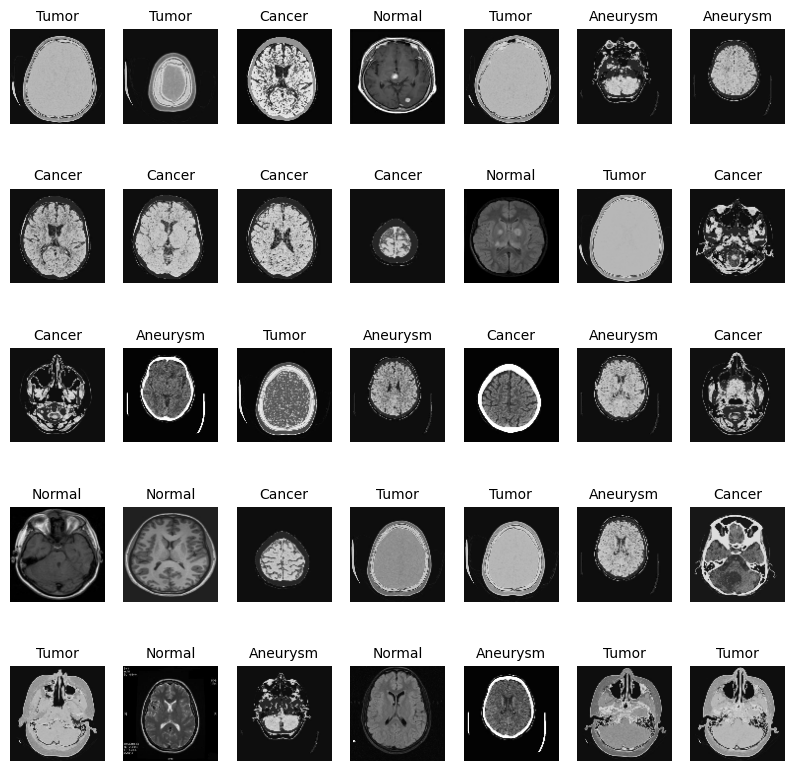

In [3]:
train_path = '/kaggle/input/brain-x-ray-images/train'
img_width,img_height,channel = 96,96,3

import os
import cv2
import random

classes = ['Aneurysm', 'Cancer', 'Tumor','Normal']

def import_data(dataset, path, categories):
    for i in categories:
        full_path = os.path.join(path, i)
        label = categories.index(i)
        for j in os.listdir(full_path):
            try:
                # Read image in grayscale (black & white)
                img = cv2.imread(os.path.join(full_path, j), cv2.IMREAD_GRAYSCALE)
                
                # Resize image
                img_resized = cv2.resize(img, (img_width, img_height))
                img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
                # Append image and label
                dataset.append([img_resized, label])
            except :
                pass
    random.shuffle(dataset)
    return dataset

# creating the dataset

train_df = []
import_data(train_df,train_path,classes)
train_df = pd.DataFrame(train_df,columns=['image','label'])
train_stack = np.stack(train_df.image)

# Images,
plt.figure(figsize=(10,10))
for i in range(35):
    plt.subplot(5,7,i+1)
    plt.imshow(train_df.image[i])
    plt.title(classes[train_df.label[i]],size=10)
    plt.axis('off')

In [4]:
# Train dataset
train_df.head(5)

,image,label
0,"[[[14, 14, 14], [14, 14, 14], [14, 14, 14], [1...",2
1,"[[[14, 14, 14], [14, 14, 14], [14, 14, 14], [1...",2
2,"[[[7, 7, 7], [7, 7, 7], [7, 7, 7], [7, 7, 7], ...",1
3,"[[[32, 32, 32], [17, 17, 17], [16, 16, 16], [1...",3
4,"[[[14, 14, 14], [14, 14, 14], [14, 14, 14], [1...",2


In [5]:
train_df.label.value_counts()

label
1    910
2    840
0    840
3    493
Name: count, dtype: int64

In [6]:
# Loading the pretrained models :
from tensorflow.keras.applications import VGG16, VGG19, ResNet101, MobileNet

#MobileNet----------------------------------------------->
mobilenet = MobileNet(
    include_top = False,
    weights='imagenet',
    input_shape = (img_width,img_height,3))

mobilenet.trainable = False

#vgg16--------------------------------------------------->
vgg16 = VGG16(
    include_top = False,
    weights='imagenet',
    input_shape = (img_width,img_height,3))

vgg16.trainable = False

#vgg19-------------------------------------------------->
vgg19 = VGG19(
    include_top = False,
    weights='imagenet',
    input_shape = (img_width,img_height,3))

vgg19.trainable = False

#Resnet101----------------------------------------------->
resnet101 = ResNet101(
    include_top = False,
    weights='imagenet',
    input_shape = (img_width,img_height,3))

resnet101.trainable = False


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# model_1 vgg16
# let's build and train the model 
model_1 = Sequential()
model_1.add(vgg16)
# ann layers
model_1.add(layers.Flatten())

model_1.add(layers.BatchNormalization())
model_1.add(layers.Dense(units=128,activation='relu',kernel_regularizer = keras.regularizers.l2(0.04)))
model_1.add(layers.Dropout(0.57))

model_1.add(layers.BatchNormalization())
model_1.add(layers.Dense(units=64,activation='relu'))
model_1.add(layers.Dropout(0.5))

#no of classes is 4
model_1.add(layers.Dense(units=4,activation='softmax'))

model_1.compile(optimizer=Adam(learning_rate=0.0007), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])


model_1.fit(train_stack,train_df.label,epochs=20, validation_split = 0.2)

Epoch 1/20
 3/78 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2917 - loss: 11.7119  

I0000 00:00:1758731872.104280      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1758731872.119403      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6206 - loss: 7.8870

W0000 00:00:1758731879.327156      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1758731880.231376      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.6224 - loss: 7.8613 - val_accuracy: 0.9887 - val_loss: 3.1373
Epoch 2/20
 6/78 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8923 - loss: 3.3752

W0000 00:00:1758731884.091621      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9316 - loss: 2.7898 - val_accuracy: 0.9968 - val_loss: 1.4102
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9524 - loss: 1.3328 - val_accuracy: 0.9984 - val_loss: 0.7508
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9652 - loss: 0.7682 - val_accuracy: 0.9903 - val_loss: 0.5241
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9674 - loss: 0.6065 - val_accuracy: 0.9935 - val_loss: 0.4670
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9608 - loss: 0.5390 - val_accuracy: 0.9887 - val_loss: 0.4387
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9630 - loss: 0.5162 - val_accuracy: 0.9919 - val_loss: 0.4107
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9696 - loss: 0.5090 - val_accuracy: 0.9887 - val_loss: 0.4566
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9665 - loss: 0.5403 - val_accuracy: 0.9935 - val_loss: 0.

<Axes: title={'center': 'VGG16'}>

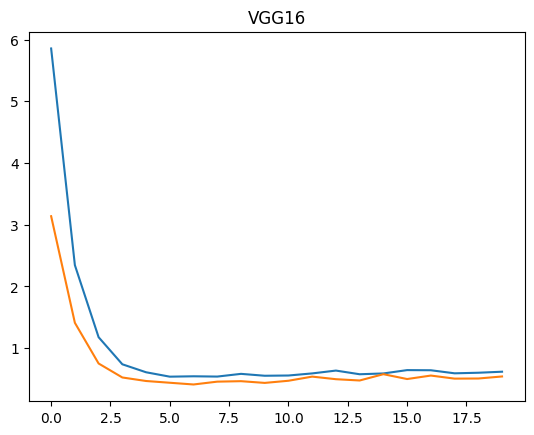

In [8]:
plt.title('VGG16')
sns.lineplot(model_1.history.history['loss'])
sns.lineplot(model_1.history.history['val_loss'])

In [9]:
# model_2 vgg19
# let's build and train the model 
model_2 = Sequential()
model_2.add(vgg19)
#ann layers
model_2.add(layers.Flatten())

model_2.add(layers.BatchNormalization())
model_2.add(layers.Dense(units=128,activation='relu', kernel_regularizer = keras.regularizers.l2(0.04)))
model_2.add(layers.Dropout(0.5))

model_2.add(layers.BatchNormalization())
model_2.add(layers.Dense(units=128,activation='relu', kernel_regularizer = keras.regularizers.l2(0.04)))
model_2.add(layers.Dropout(0.5))

#no of classes is 4
model_2.add(layers.Dense(units=4,activation='softmax'))

model_2.compile(optimizer=Adam(learning_rate=0.0007), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_2.fit(train_stack,train_df.label,epochs=20, validation_split = 0.2)

Epoch 1/20
 5/78 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2461 - loss: 16.5901

W0000 00:00:1758731938.472493      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6533 - loss: 12.1965

W0000 00:00:1758731944.496748      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1758731945.487456      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.6554 - loss: 12.1607 - val_accuracy: 0.9854 - val_loss: 5.2317
Epoch 2/20
 5/78 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9516 - loss: 5.3096

W0000 00:00:1758731946.750508      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9677 - loss: 4.3625 - val_accuracy: 0.9870 - val_loss: 2.1504
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9792 - loss: 1.8404 - val_accuracy: 0.9903 - val_loss: 1.0167
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9869 - loss: 0.9133 - val_accuracy: 0.9903 - val_loss: 0.6022
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9842 - loss: 0.5788 - val_accuracy: 0.9919 - val_loss: 0.4227
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9827 - loss: 0.4481 - val_accuracy: 0.9887 - val_loss: 0.3558
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9855 - loss: 0.3931 - val_accuracy: 0.9854 - val_loss: 0.3825
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9833 - loss: 0.4166 - val_accuracy: 0.9919 - val_loss: 0.3145
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9880 - loss: 0.3906 - val_accuracy: 0.9870 - val_loss: 0.

<Axes: title={'center': 'VGG19'}>

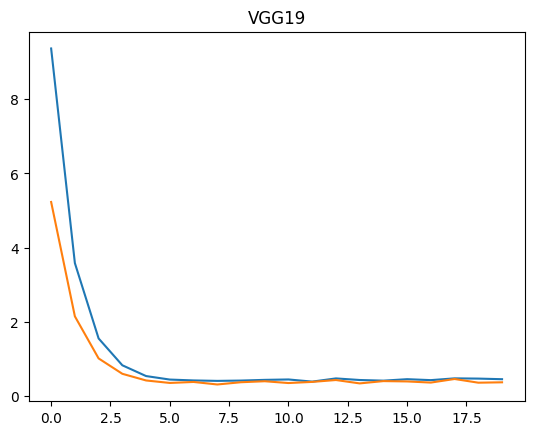

In [10]:
plt.title('VGG19')
sns.lineplot(model_2.history.history['loss'])
sns.lineplot(model_2.history.history['val_loss'])

In [11]:
# model_3 Resnet101
 
# let's build and train the model 
model_3 = Sequential()
model_3.add(resnet101)
#ann layers
model_3.add(layers.Flatten())

# model_6.add(layers.BatchNormalization())
model_3.add(layers.Dense(units=64,activation='relu'))
model_3.add(layers.Dropout(0.4))


#no of classes is 4
model_3.add(layers.Dense(units=4,activation='softmax'))

model_3.compile(optimizer=Adam(learning_rate=0.0009), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])


model_3.fit(train_stack,train_df.label,epochs=20, validation_split = 0.2)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7920 - loss: 1.0361

W0000 00:00:1758732040.485125      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.7931 - loss: 1.0287 - val_accuracy: 0.9903 - val_loss: 0.0286
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9539 - loss: 0.1217 - val_accuracy: 0.9903 - val_loss: 0.0148
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9701 - loss: 0.0843 - val_accuracy: 0.9903 - val_loss: 0.0283
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9615 - loss: 0.0875 - val_accuracy: 0.9903 - val_loss: 0.0218
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9708 - loss: 0.0716 - val_accuracy: 0.9870 - val_loss: 0.0397
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9706 - loss: 0.0944 - val_accuracy: 0.9887 - val_loss: 0.0197
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9807 - loss: 0.0546 - val_accuracy: 0.9887 - val_loss: 0.0209
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9785 - loss: 0.0405 - val_accuracy: 0.9887 - val_loss: 

<Axes: title={'center': 'Resnet101'}>

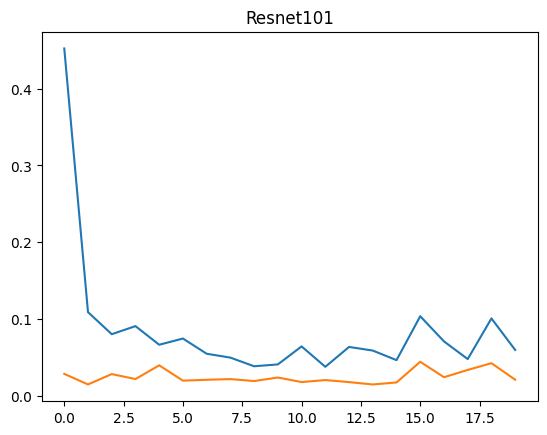

In [12]:
plt.title('Resnet101')
sns.lineplot(model_3.history.history['loss'])
sns.lineplot(model_3.history.history['val_loss'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,start_from_epoch=25)

In [14]:
# model_4  vgg16 + cnn
tf.random.set_seed(23)
# let's build and train the model 
model_4 = Sequential()
model_4.add(vgg16)
model_4.add(layers.Conv2D(32,(4,4),padding = 'same',activation = 'relu'))
model_4.add(layers.Dropout(0.2))

# ann layers
model_4.add(layers.Flatten())
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(units=64,activation='relu',kernel_regularizer = keras.regularizers.l2(0.04)))
model_4.add(layers.Dropout(0.2))

#no of classes is 4
model_4.add(layers.Dense(units=4,activation='softmax'))
model_4.compile(optimizer=Adam(learning_rate=0.00015), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_4.fit(train_stack, train_df. label,epochs=20, validation_split = 0.2, callbacks = early_stopping)

Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.6089 - loss: 5.2188 - val_accuracy: 0.9806 - val_loss: 3.8875
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9615 - loss: 3.8489 - val_accuracy: 0.9870 - val_loss: 3.3672
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9847 - loss: 3.2902 - val_accuracy: 0.9903 - val_loss: 2.8896
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9881 - loss: 2.8048 - val_accuracy: 0.9903 - val_loss: 2.4529
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9918 - loss: 2.3794 - val_accuracy: 0.9870 - val_loss: 2.0720
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9928 - loss: 2.0045 - val_accuracy: 0.9870 - val_loss: 1.7418
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9908 - loss: 1.6798 - val_accuracy: 0.9903 - val_loss: 1.4544
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9906 - loss: 1.4123 - val_accuracy: 0.9903 -

<Axes: title={'center': 'VGG16+CNN'}>

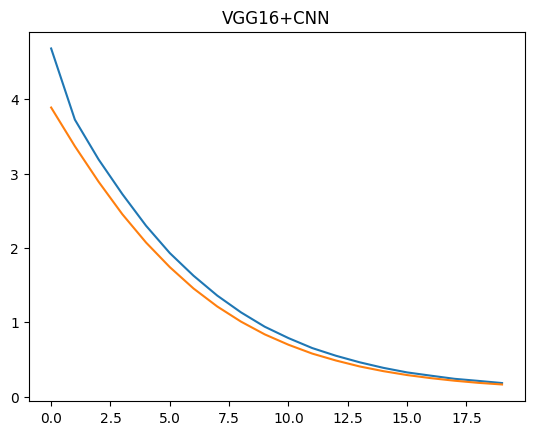

In [15]:
plt.title('VGG16+CNN')
sns.lineplot(model_4.history.history['loss'])
sns.lineplot(model_4.history.history['val_loss'])

In [16]:
# model_5 MobileNet

# let's build and train the model 
model_5 = Sequential()
model_5.add(mobilenet)
#ann layers
model_5.add(layers.Flatten())
model_5.add(layers.Dense(units=128,activation='relu'))
model_5.add(layers.Dropout(0.5))

#no of classes is 4
model_5.add(layers.Dense(units=4,activation='softmax'))

model_5.compile(optimizer=Adam(learning_rate=0.0009), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])


model_5.fit(train_stack,train_df.label,epochs=20, validation_split = 0.2)

Epoch 1/20
25/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5567 - loss: 2.9880

W0000 00:00:1758732197.783068      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7240 - loss: 1.7370

W0000 00:00:1758732201.777121      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1758732203.802437      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.7257 - loss: 1.7246 - val_accuracy: 0.9789 - val_loss: 0.0546
Epoch 2/20
25/78 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9556 - loss: 0.1221

W0000 00:00:1758732206.209298      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9591 - loss: 0.1181 - val_accuracy: 0.9870 - val_loss: 0.0390
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9704 - loss: 0.0685 - val_accuracy: 0.9870 - val_loss: 0.0507
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9720 - loss: 0.0581 - val_accuracy: 0.9903 - val_loss: 0.0301
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9752 - loss: 0.0616 - val_accuracy: 0.9887 - val_loss: 0.0355
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9740 - loss: 0.0534 - val_accuracy: 0.9870 - val_loss: 0.0292
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9815 - loss: 0.0485 - val_accuracy: 0.9951 - val_loss: 0.0195
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9766 - loss: 0.0467 - val_accuracy: 0.9854 - val_loss: 0.0289
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9801 - loss: 0.0483 - val_accuracy: 0.9870 - val_loss: 0.0332
Epo

<Axes: title={'center': 'MobileNet'}>

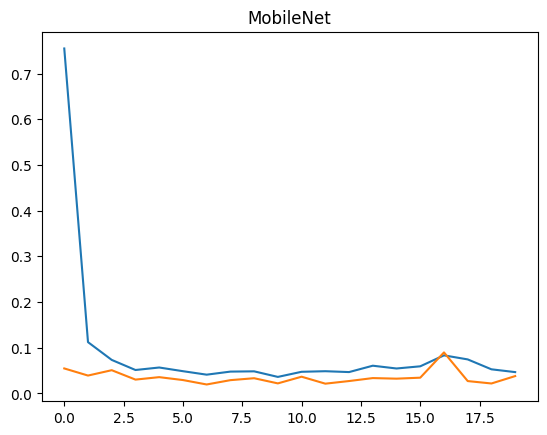

In [17]:
plt.title('MobileNet')
sns.lineplot(model_5.history.history['loss'])
sns.lineplot(model_5.history.history['val_loss'])

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True,start_from_epoch=25)

In [19]:
# model_6  VGG16+ 2CNN

# let's build and train the model 
model_6 = Sequential()
model_6.add(vgg16)
model_6.add(layers.Conv2D(32,(3,3),padding='same',
                           activation = 'relu',
                           kernel_regularizer = keras.regularizers.l2(0.04)))
model_6.add(layers.Dropout(0.4))
model_6.add(layers.Conv2D(32,(5,5),padding='same',
                           activation = 'relu',
                           kernel_regularizer = keras.regularizers.l2(0.04)))
model_6.add(layers.Dropout(0.4))
# ann layers
model_6.add(layers.Flatten())
model_6.add(layers.BatchNormalization())
model_6.add(layers.Dense(units=64,activation='relu',kernel_regularizer = keras.regularizers.l2(0.04)))
model_6.add(layers.Dropout(0.5))

#no of classes is 4
model_6.add(layers.Dense(units=4,activation='softmax'))
model_6.compile(optimizer=Adam(learning_rate=0.00015),
                 loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_6.fit(train_stack,train_df.label,epochs=80, validation_split = 0.2, callbacks= early_stopping)


Epoch 1/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.3495 - loss: 9.3573 - val_accuracy: 0.8120 - val_loss: 7.6304
Epoch 2/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5460 - loss: 7.9438 - val_accuracy: 0.9044 - val_loss: 6.7696
Epoch 3/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6464 - loss: 7.0581 - val_accuracy: 0.9595 - val_loss: 6.1094
Epoch 4/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7714 - loss: 6.3196 - val_accuracy: 0.9757 - val_loss: 5.5703
Epoch 5/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8191 - loss: 5.7226 - val_accuracy: 0.9806 - val_loss: 5.0840
Epoch 6/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8622 - loss: 5.2076 - val_accuracy: 0.9822 - val_loss: 4.6503
Epoch 7/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9064 - loss: 4.7053 - val_accuracy: 0.9838 - val_loss: 4.2555
Epoch 8/80
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9200 - loss: 4.3221 - val_accuracy: 0.9870 -

<Axes: title={'center': 'VGG16+ 2CNN'}>

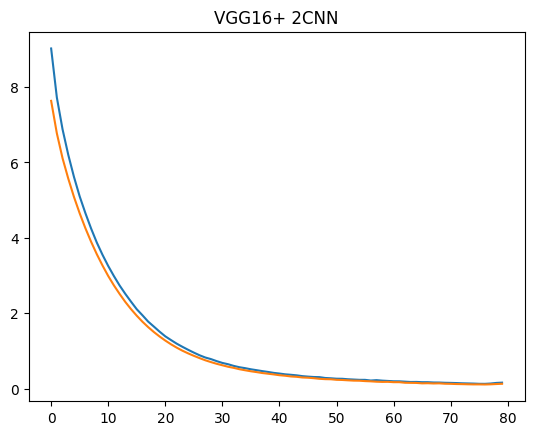

In [20]:
plt.title('VGG16+ 2CNN')
sns.lineplot(model_6.history.history['loss'])
sns.lineplot(model_6.history.history['val_loss'])


In [21]:
models = [model_1,model_2,model_3,model_4,model_5,model_6]
models_name = {model_1:'VGG16', model_2:'VGG19', model_3:'Resnet101',
               model_4:'VGG16+CNN', model_5:'MobileNet', model_6:'VGG16+ 2CNN'}

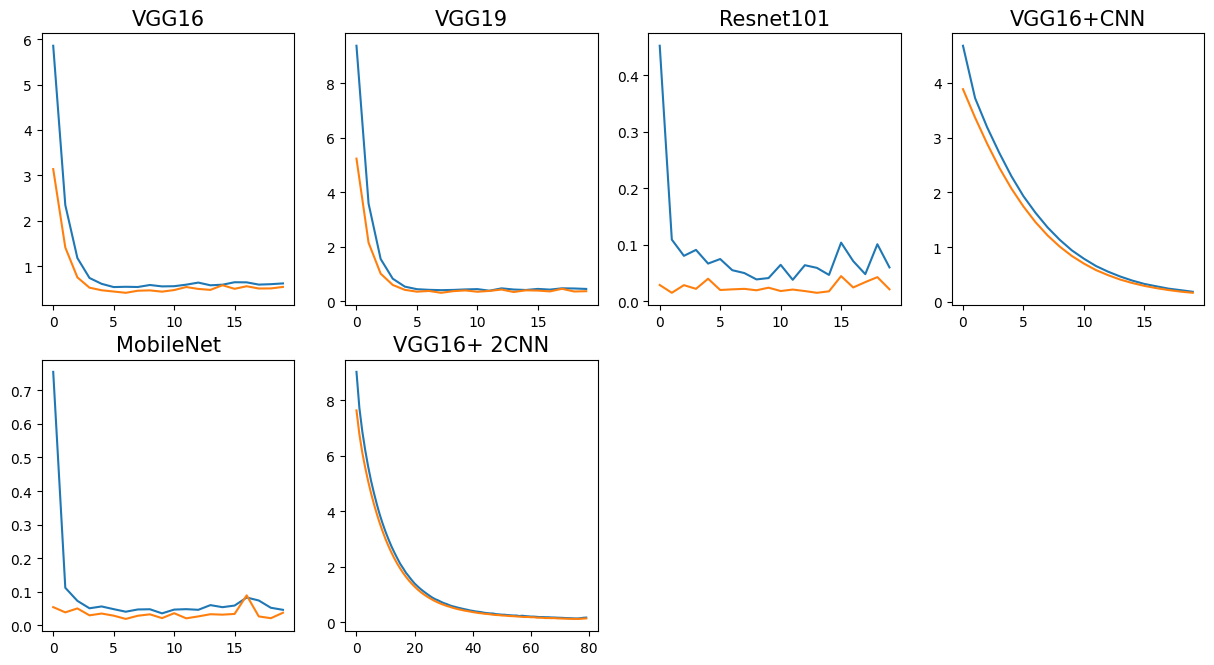

In [22]:
plt.figure(figsize = (15,12))

for i in range(len(models)):
    # creating 12 subplots as we have 12 models
    plt.subplot(3,4,i+1)
    plt.title(f'{models_name[models[i]]}',size=15)
    sns.lineplot(models[i].history.history['loss'])
    sns.lineplot(models[i].history.history['val_loss'])

In [23]:
# Now we will do the predictions on the test data:
test_path = '/kaggle/input/brain-x-ray-images/test'
test_df = []
import_data(test_df, test_path, classes)
test_df = pd.DataFrame(test_df,columns=['image','label'])
test_stack = np.stack(test_df.image)

In [24]:
#let's print the test dataset
test_df.head(5)

,image,label
0,"[[[7, 7, 7], [7, 7, 7], [7, 7, 7], [7, 7, 7], ...",1
1,"[[[16, 16, 16], [16, 16, 16], [16, 16, 16], [1...",1
2,"[[[0, 0, 0], [0, 0, 0], [1, 1, 1], [0, 0, 0], ...",3
3,"[[[7, 7, 7], [7, 7, 7], [7, 7, 7], [7, 7, 7], ...",1
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3


In [25]:
# importing some performance metrices :
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [26]:
def  prediction(model,test_stack = test_stack, test_df = test_df):
    ''' we will take the different models and do the predictions '''
    
    output = model.predict(test_stack)
    prediction = [np.argmax(i) for i in output]
    print("-"*60)
    print(f'Model Name - {models_name[model]}')
    print(f'Accuracy Score : {accuracy_score(test_df.label,prediction)}')
    print(f'Precision Score : {precision_score(test_df.label,prediction, average="weighted")}')
    print(f'Recall Score : {recall_score(test_df.label,prediction, average="weighted")}')
    print(f'F1 Score : {f1_score(test_df.label,prediction, average="weighted")}')
    print()
    
for i in models:
    prediction(i)

 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

W0000 00:00:1758732485.402178      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 411ms/step


W0000 00:00:1758732493.203498      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


------------------------------------------------------------
Model Name - VGG16
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0

 6/20 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

W0000 00:00:1758732494.116212      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


W0000 00:00:1758732495.430414      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


------------------------------------------------------------
Model Name - VGG19
Accuracy Score : 0.9984326018808778
Precision Score : 0.9984645895975945
Recall Score : 0.9984326018808778
F1 Score : 0.9984398872312888

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 556ms/step
------------------------------------------------------------
Model Name - Resnet101
Accuracy Score : 0.9984326018808778
Precision Score : 0.9984645895975945
Recall Score : 0.9984326018808778
F1 Score : 0.9984398872312888

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
------------------------------------------------------------
Model Name - VGG16+CNN
Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0

17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

W0000 00:00:1758732517.153293      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step


W0000 00:00:1758732520.588970      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


------------------------------------------------------------
Model Name - MobileNet
Accuracy Score : 0.9984326018808778
Precision Score : 0.9984645895975945
Recall Score : 0.9984326018808778
F1 Score : 0.9984398872312888

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
------------------------------------------------------------
Model Name - VGG16+ 2CNN
Accuracy Score : 0.9984326018808778
Precision Score : 0.9984645895975945
Recall Score : 0.9984326018808778
F1 Score : 0.9984398872312888



#### Observation :
* Densenet121, VGG16 with CNN's are performing best.
* Achieved a accuracy of 98.10% 

In [27]:
plot_number = 0
def  plot_confusion_matrix(model,test_stack = test_stack, test_df = test_df):
    ''' we will Print the confusion matrix '''
    
    output = model.predict(test_stack)
    prediction = [np.argmax(i) for i in output]
    accuracy = accuracy_score(test_df.label,prediction)
    # where the accuracy is more than 94% we will show the CM as blue...
    if accuracy > 0.94:
        cmap = 'Blues'
    else :
        cmap = 'Reds'
    cm = confusion_matrix(test_df.label, prediction)
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='g')  
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {models_name[model]}')
    plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


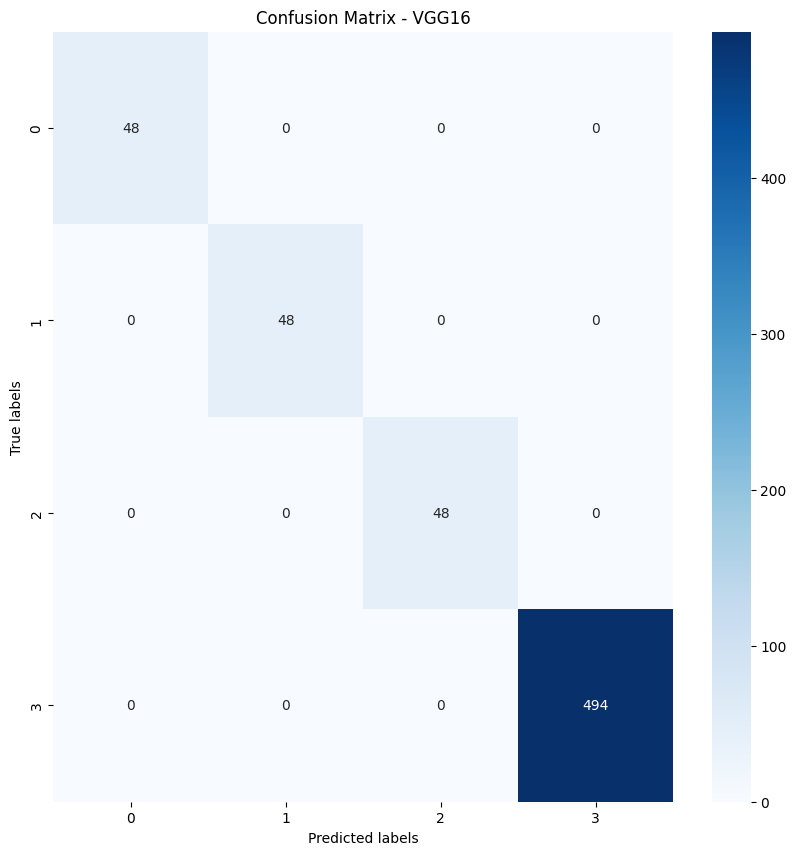

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


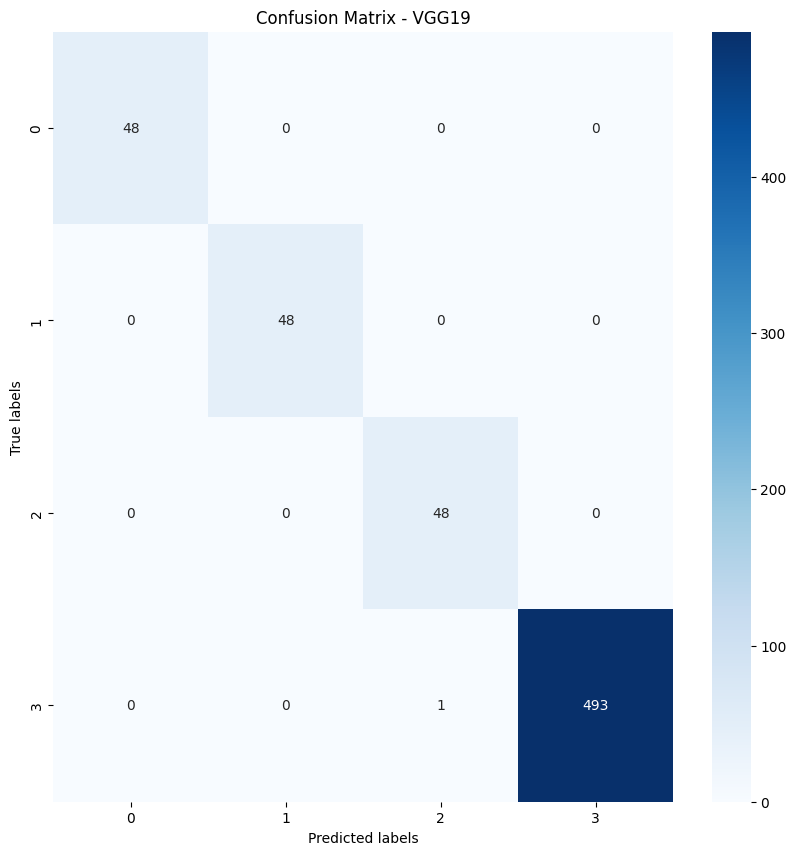

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


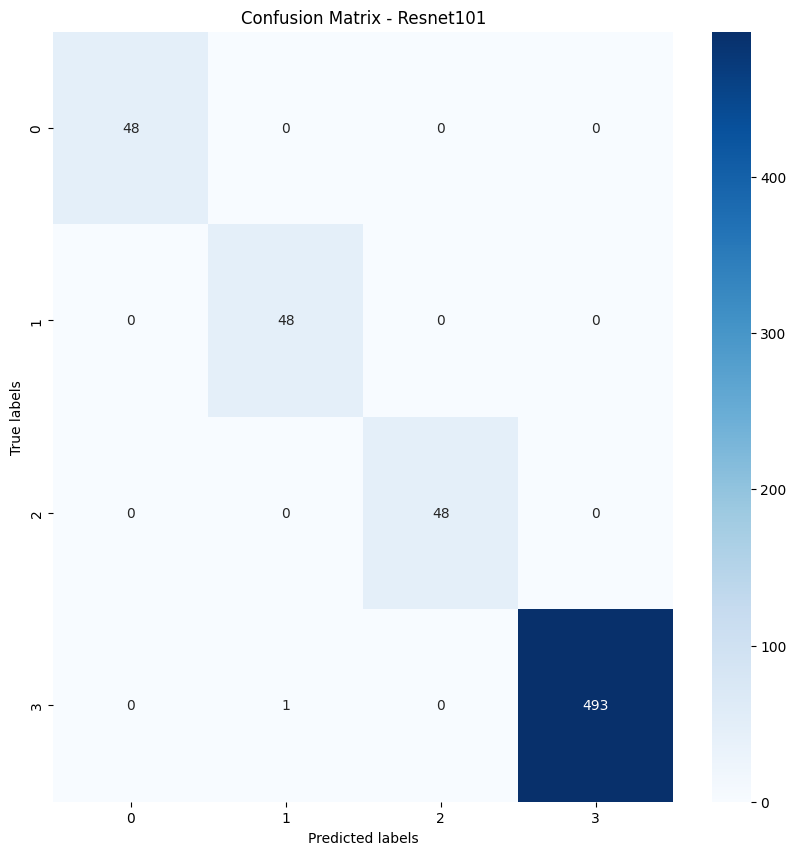

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


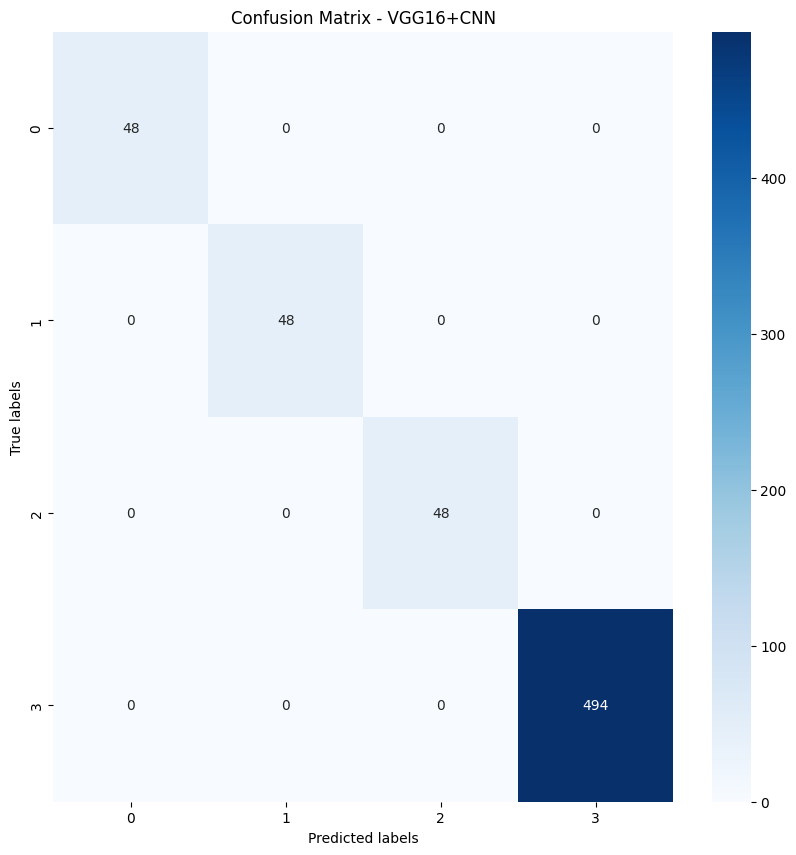

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


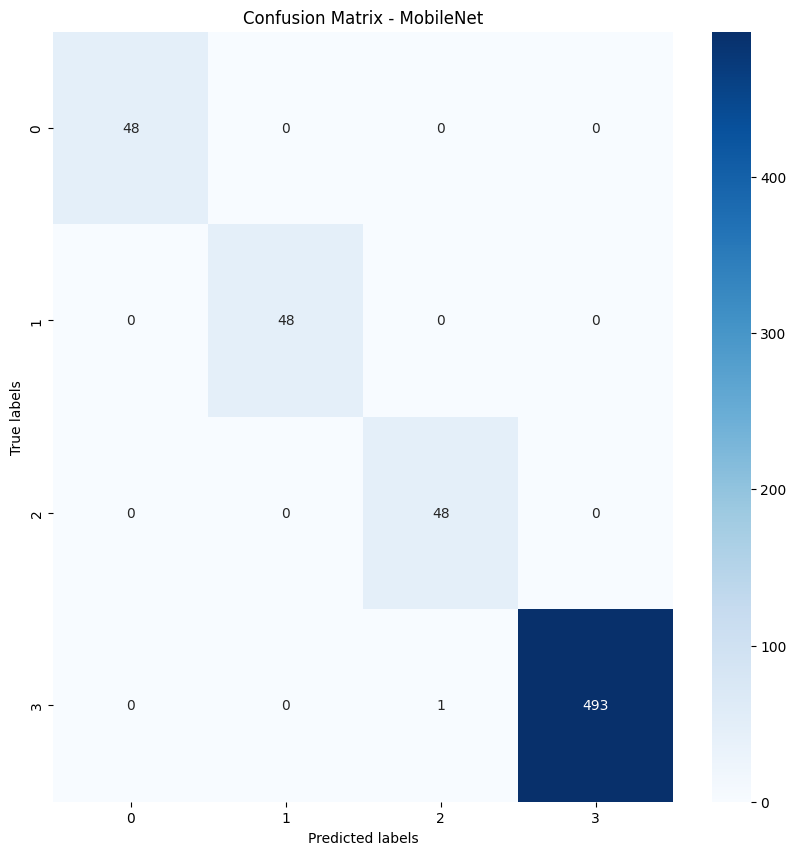

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


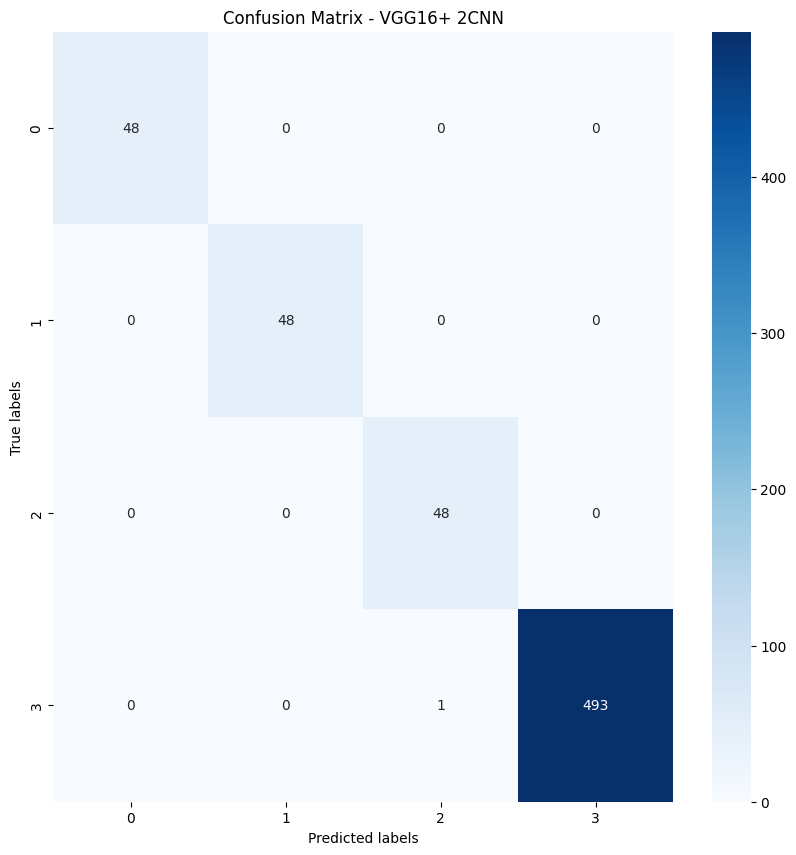

In [28]:
for i in models:
    plot_number = plot_number+1
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(i)

In [29]:
model_6.save("Brain_X_ray_Img_Detection_model.keras")